In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def BQART(B,Q,A,R,T):
    if(T>=2):
        Qs = 0.02 * B * (Q**0.31) * (A**0.5) * R * T
    else:
        Qs = 0.04 * B * (Q**0.31) * (A**0.5) * R
    return Qs

def PsiModel(Q,Q_bar,Qs_bar,psi,c):
    return Qs_bar * psi * ((Q/Q_bar)**c)


#https://waterdata.usgs.gov/monitoring-location/07374000
gageFile = '07374000.txt'
gage = pd.read_csv(gageFile,sep='\t',header=33,
                    usecols = ['20d','14n'],
                    parse_dates=['20d'],
                    low_memory=False)

gage = gage.rename(columns={'20d':'datetime', '14n':'Q'})
gage = gage.set_index('datetime')
gage.Q = pd.to_numeric(gage.Q,errors='coerce')
gage.Q = gage.Q * (0.3048**3) #cfs to cms
gage.Q.dropna(inplace=True)

daily = gage.resample('D').mean().interpolate()
daily['Q_hyst'] = np.roll(daily.Q,5) #Add some hysteresis for fun 
daily = daily[daily.index > '2007-01-01']

## watershed variables
Q_bar = np.mean(daily.Q) #mean annual cms
A = 1125810 * (1.61**2) #basin upstream area km^2
R = 4.4 #basin relief in km. Highest point to current cell.
T = 20 #basin average Temperature
Ag = 0 #glaciated area. Ag from [1-10] corresponds to 0-100% ice cover
I = 1 + (0.09 * Ag) #glacial erosion factor
L = 2 #lithology factor. [0.5-3] Based on Syvitski and Milliman figure 5.
Te = 0.4 #trapping efficiency of dams
Eh = 1.2 #human factor on soil erosion
B = I * L * (1-Te) * Eh


#PSI MODEL
Q_s_bar = BQART(B,Q_bar,A,R,T)
E_psi = 1
std_psi = 0.763 * (0.99995**Q_bar)
E_C = 1.4 - (0.025*T) + (0.00013*R) + (0.145*np.log(Q_s_bar))
std_C = 0.17 + (0.0000183*Q_bar)

montecarlo_num = 1000
mc_psi = np.random.lognormal(np.log(E_psi),std_psi,montecarlo_num)
mc_C = np.random.normal(E_C,std_C,montecarlo_num)

Q_s = np.full((len(daily['Q']),montecarlo_num),np.nan)
for i in range(montecarlo_num):
    Q_s[:,i] = [PsiModel(Q,Q_bar,Q_s_bar,mc_psi[i],mc_C[i]) for Q in daily['Q']]
summary = np.quantile(Q_s,[0.05, 0.5, 0.95],axis=1)
daily['Q_s'] = summary[1,:]
daily['SSC'] = daily['Q_s'] / daily['Q'] # g/L

daily.to_parquet("synthetic_daily.parquet", engine='pyarrow')

Text(0, 0.5, 'SSC')

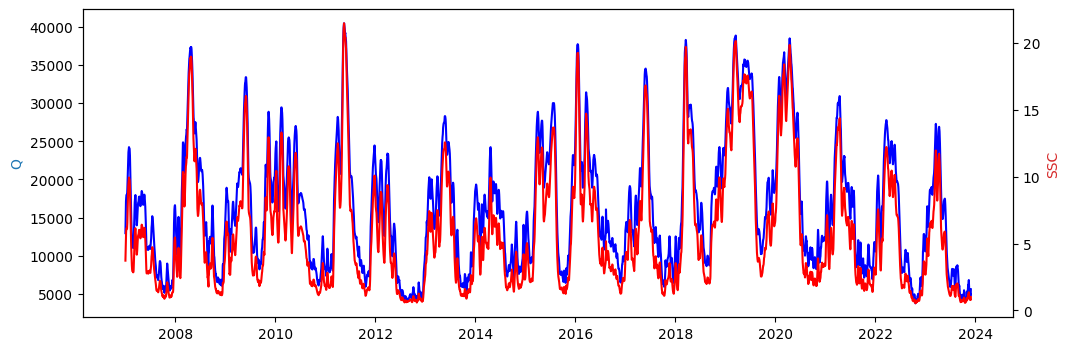

In [5]:
plt.close('all')
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(daily.index, daily['Q'], color='b')
ax1.set_ylabel('Q', color='tab:blue')
# Plot the ssc on a second y-axis
ax2 = ax1.twinx()
ax2.plot(daily.index, daily['SSC'], color='r')
ax2.set_ylabel('SSC', color='tab:red')